Want to calculate the sun hours at a specific house in Bergen


In [18]:
import numpy as np
import pandas as pd

import pysolar as ps
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import xarray as xr

import earthpy as es

from shapely.geometry import Point

import geopandas as gpd

In [2]:
dates=pd.date_range('15-04-2021','16-04-2021',freq='H',tz='Europe/Oslo')
dates_UTC = dates.tz_convert('UTC')

In [3]:
a =[pd.Timestamp(date) for date in dates_UTC]

In [4]:
dates_UTC.day_of_year

Int64Index([104, 104, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105,
            105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105],
           dtype='int64')

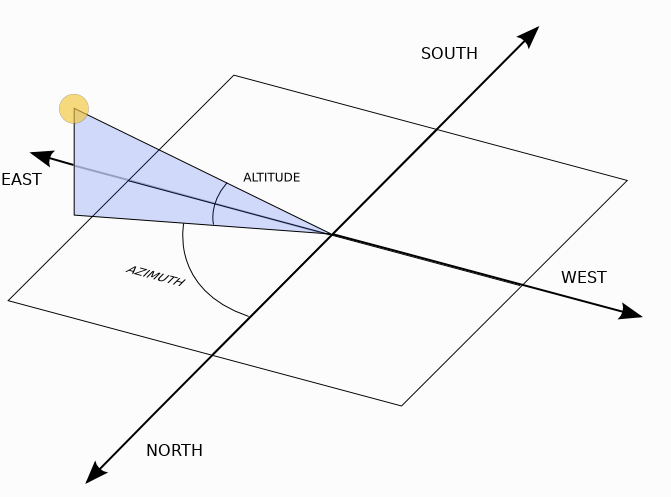


In [5]:
azimuth= np.array([ps.solar.get_azimuth(60,5,aa) for aa in a])
zenith = np.array([ps.solar.get_altitude(60,5,aa) for aa in a])
declin = np.array(ps.solar.get_declination(104))

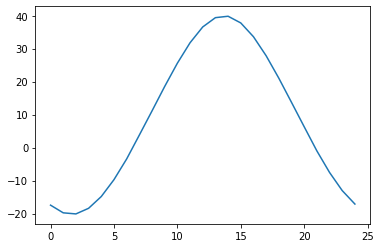

In [6]:
fig,ax  =plt.subplots()
ax.plot(zenith)

Then; we need to load in topography data

Let's start with a very simple topography

# How much sun does this house actually get? 

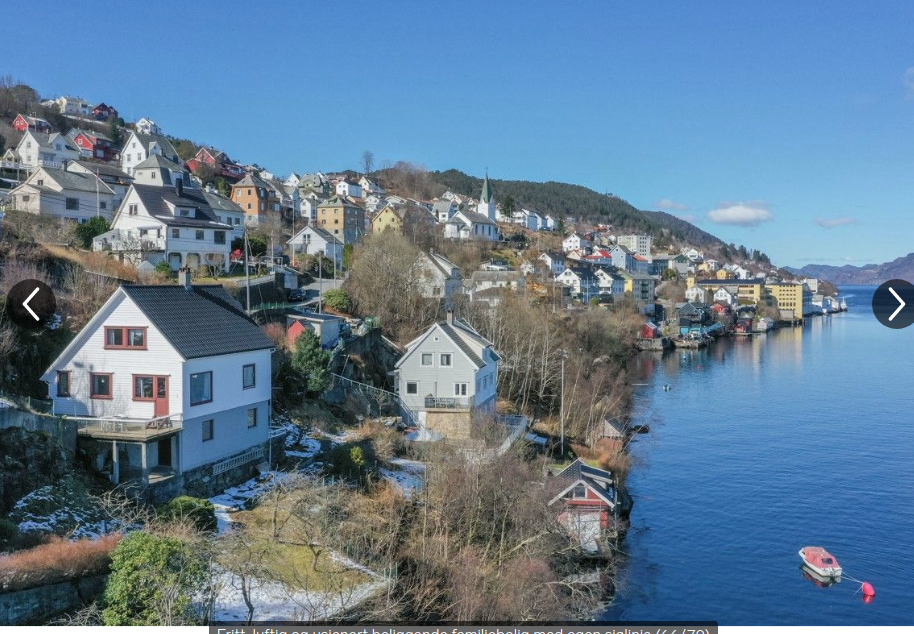



In [96]:
lat_ = 60.456752213904245
lon_ = 5.443853229924588

geom=[Point(lon_, lat_)]
gdf=gpd.GeoDataFrame(geometry=geom,crs='epsg:4326')


In [97]:
dates=pd.date_range('01-01-2021','01-01-2022',freq='H',tz='Europe/Oslo')
dates_UTC = dates.tz_convert('UTC')

a = [pd.Timestamp(date) for date in dates_UTC]

In [98]:
azimuth= np.array([ps.solar.get_azimuth(lat_,lon_,aa) for aa in a])
zenith = np.array([ps.solar.get_altitude(lat_,lon_,aa) for aa in a])
declin = np.array([ps.solar.get_declination(doy) for doy in np.arange(1,366)])

/home/kko033/anaconda3/envs/extreme_precip/lib/python3.7/site-packages/pysolar/solartime.py:114: UserWarning: I don't know about leap seconds after 2020
  (leap_seconds_base_year + len(leap_seconds_adjustments) - 1)


In [99]:
#put it in a dataframe for better accesing
sun_df = pd.DataFrame(columns=dates_UTC,data=[azimuth,zenith],index=['azimuth','zenith']).transpose()

<AxesSubplot:>

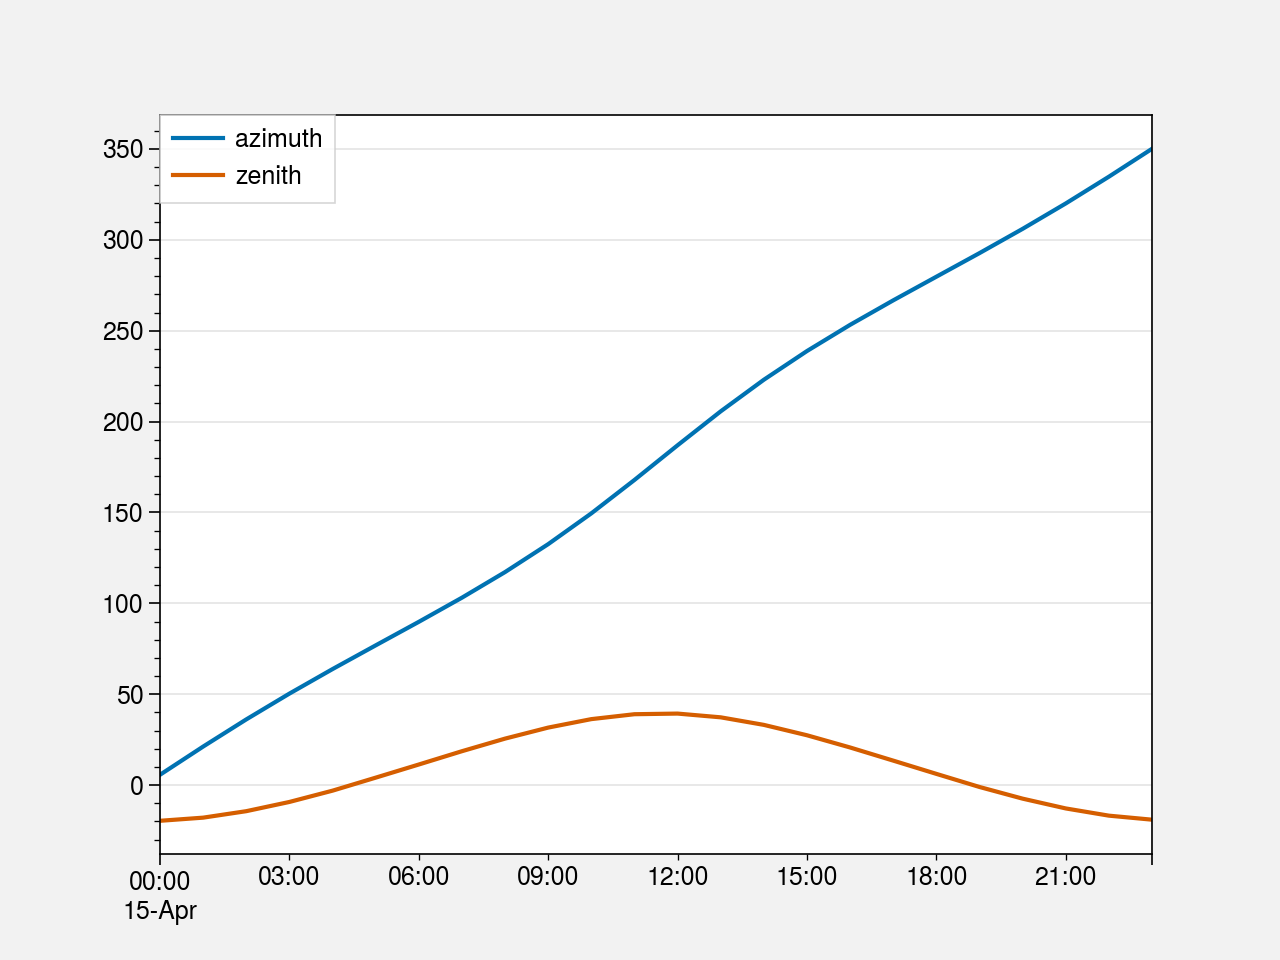

In [100]:
sun_today = sun_df.loc['2021-04-15']
sun_today.plot()

And then, need topography

In [101]:
dtm50 = xr.open_rasterio('dtm50/data/dtm50_3395.tif')
import rasterio as rio
dtm50_ll = rio.open('dtm50/data/dtm50_3395.tif')

In [102]:
dtm50_ll.plot(vmin=0)

AttributeError: 'DatasetReader' object has no attribute 'plot'

In [103]:
from pyproj import CRS

In [104]:
circle_gdf.geometry

0    POLYGON ((6740014.871 602870.000, 6739966.719 ...
Name: geometry, dtype: geometry

<AxesSubplot:>

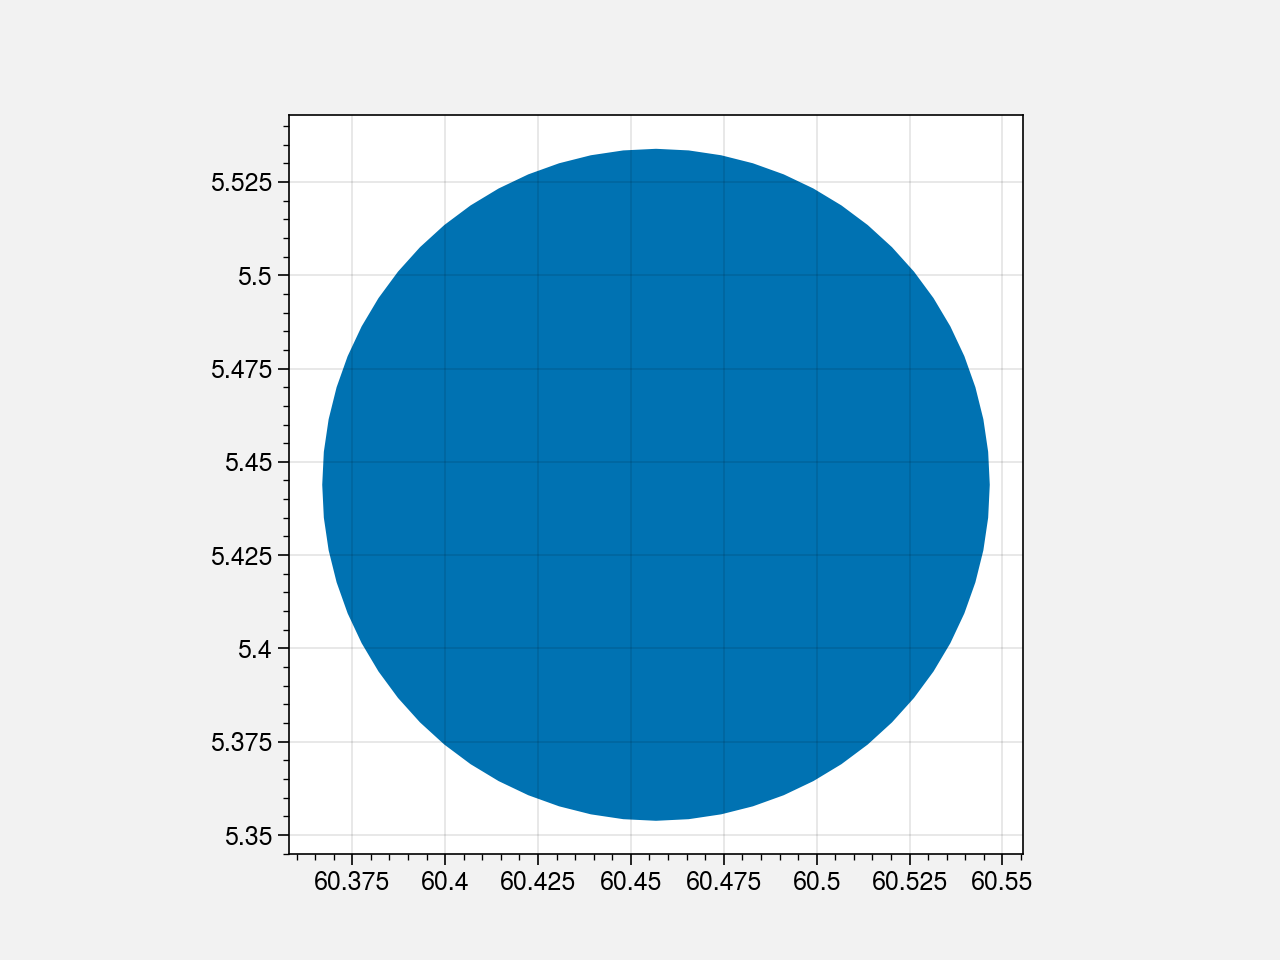

In [105]:
circle_gdf.to_crs('epsg:4326').geometry.plot()

In [106]:
circle = gdf.to_crs(epsg=3395).buffer(10e3)
circle_gdf = gpd.GeoDataFrame({'buffer' : 'circle', 'geometry' : circle},crs = CRS('epsg:3395'))

In [108]:
gdf.to_crs(epsg=3395,inplace=True)

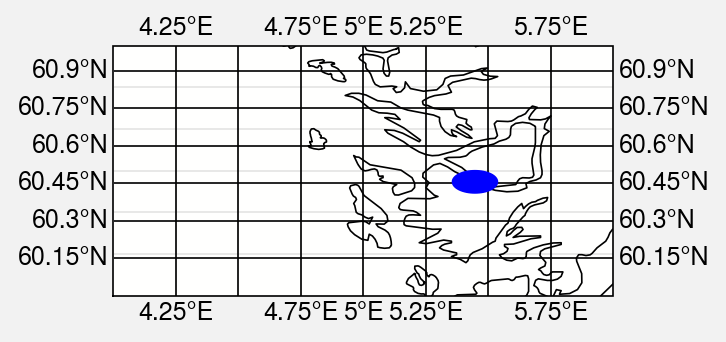

In [117]:
import proplot as plot
fig,ax = plot.subplots(projection=ccrs.PlateCarree())
ax.set_extent([4,6,60,61])
ax.coastlines()
#ax.scatter(lon_,lat_,transform=ccrs.PlateCarree(),color='b')

ax.add_geometries(circle_gdf.to_crs('epsg:4326').geometry,
                  zorder=50,crs=ccrs.PlateCarree(),color='blue')
ax.gridlines(draw_labels=True)
ax.pcoloremsh(dtm50.squeeze(),vmin=0)

Then, I have to find the topography within this, and for every angle, I have to find all the topography within the circle

In [852]:
circle

0    POLYGON ((616006.970 8464929.207, 615958.817 8...
dtype: geometry

In [160]:

import earthpy.spatial as es
cropped,cropped_meta = es.crop_image(dtm50_ll,circle)

POI = gdf

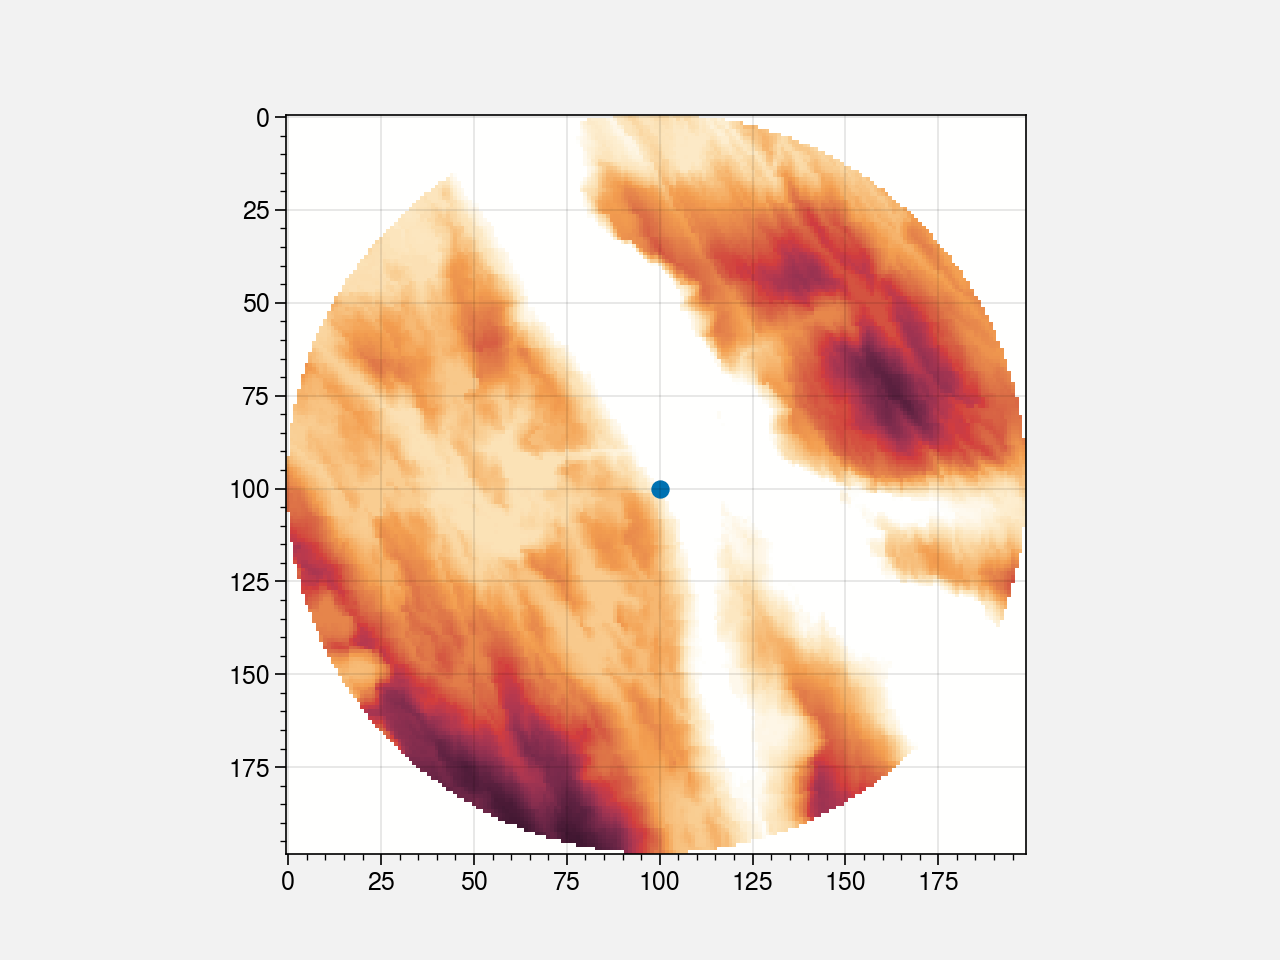

In [406]:
plt.imshow(cropped.squeeze(),vmin=0)
plt.scatter(100,100)

x = np.arange(-100,99)
y = np.arange(-100,99)[::-1]

In [238]:
cropped[cropped<0] = 0

## We have managed to clip the data: 
- Next step is then to transform the data into polar coordinates

In [407]:
def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(rho, phi)

rho,phi = cart2pol(np.arange(0,100),np.arange(0,100))


/home/kko033/anaconda3/envs/extreme_precip/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


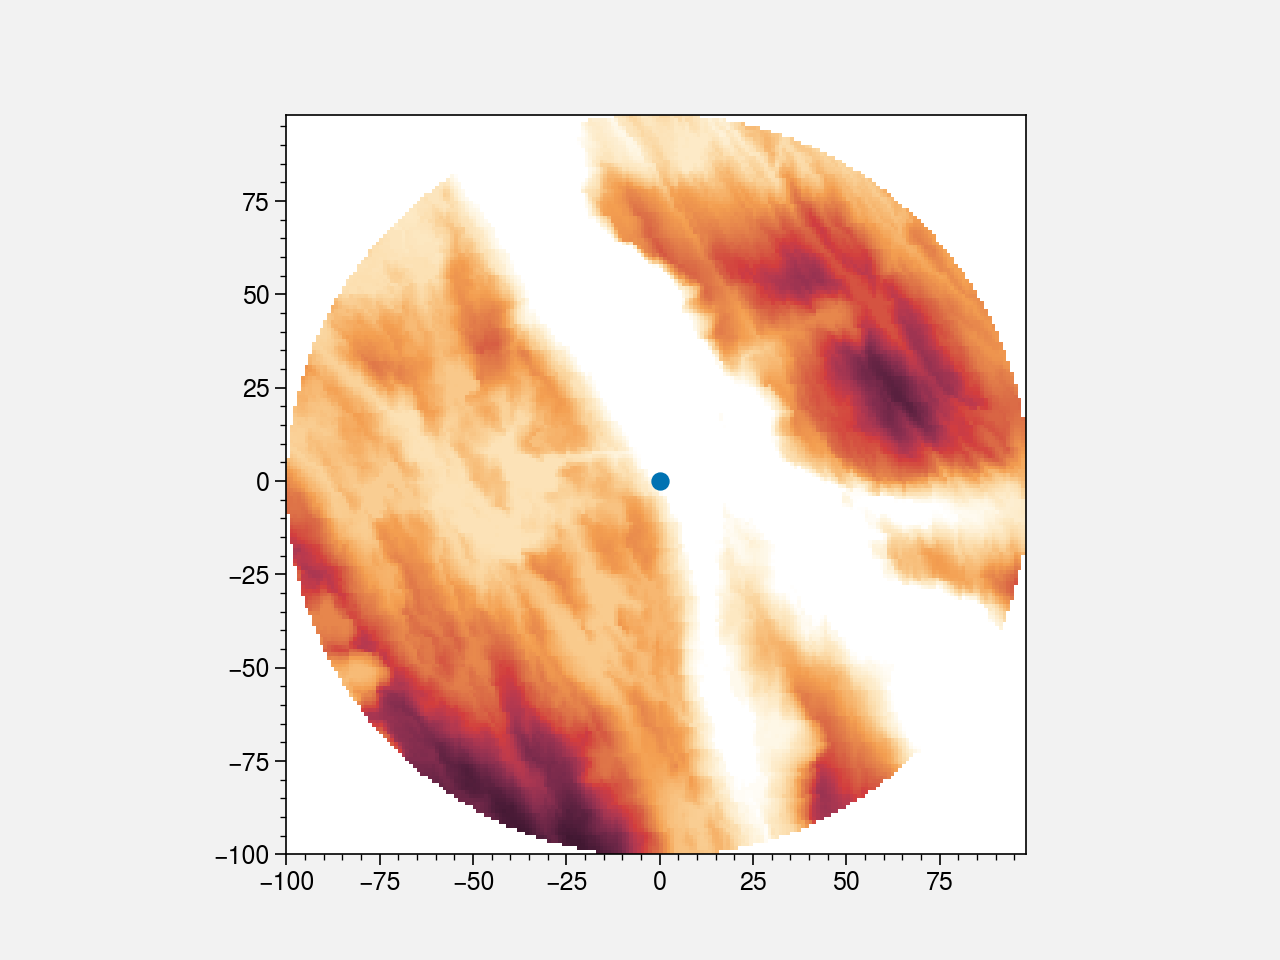

In [240]:
fig,ax = plt.subplots()
ax.pcolormesh(x,y,cropped.squeeze())
ax.scatter(0,0)
ax.set_aspect(1)

Extract a test line, starting straight east, which will be a constant y = 0, x > 0

In [484]:
topo = cropped.squeeze()
#topo_east = topo[x<0,y==0]

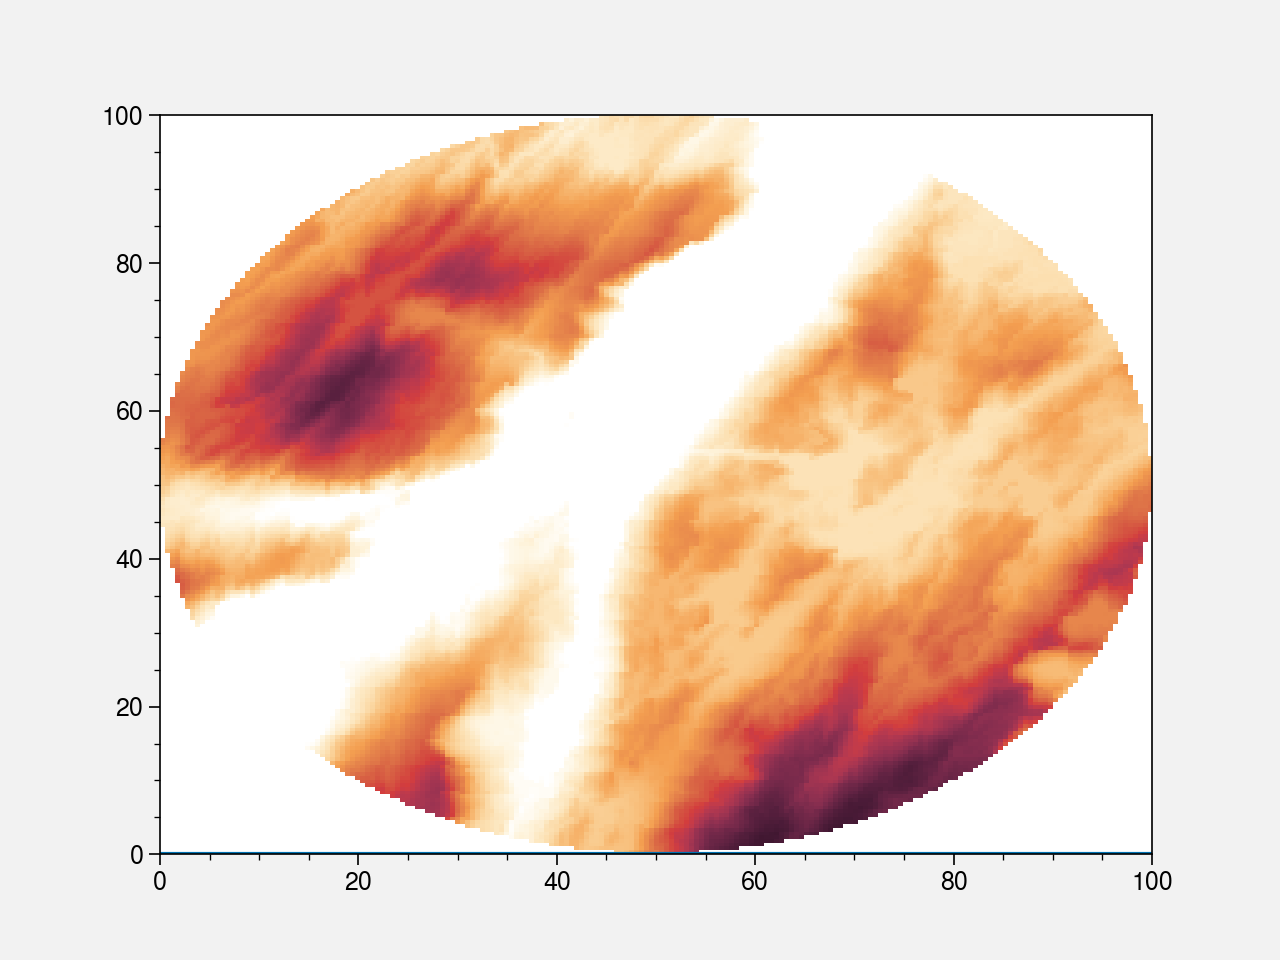

In [485]:
plt.pcolormesh(x,y,topo)
plt.hlines(y = 0,xmin=0,xmax=100)

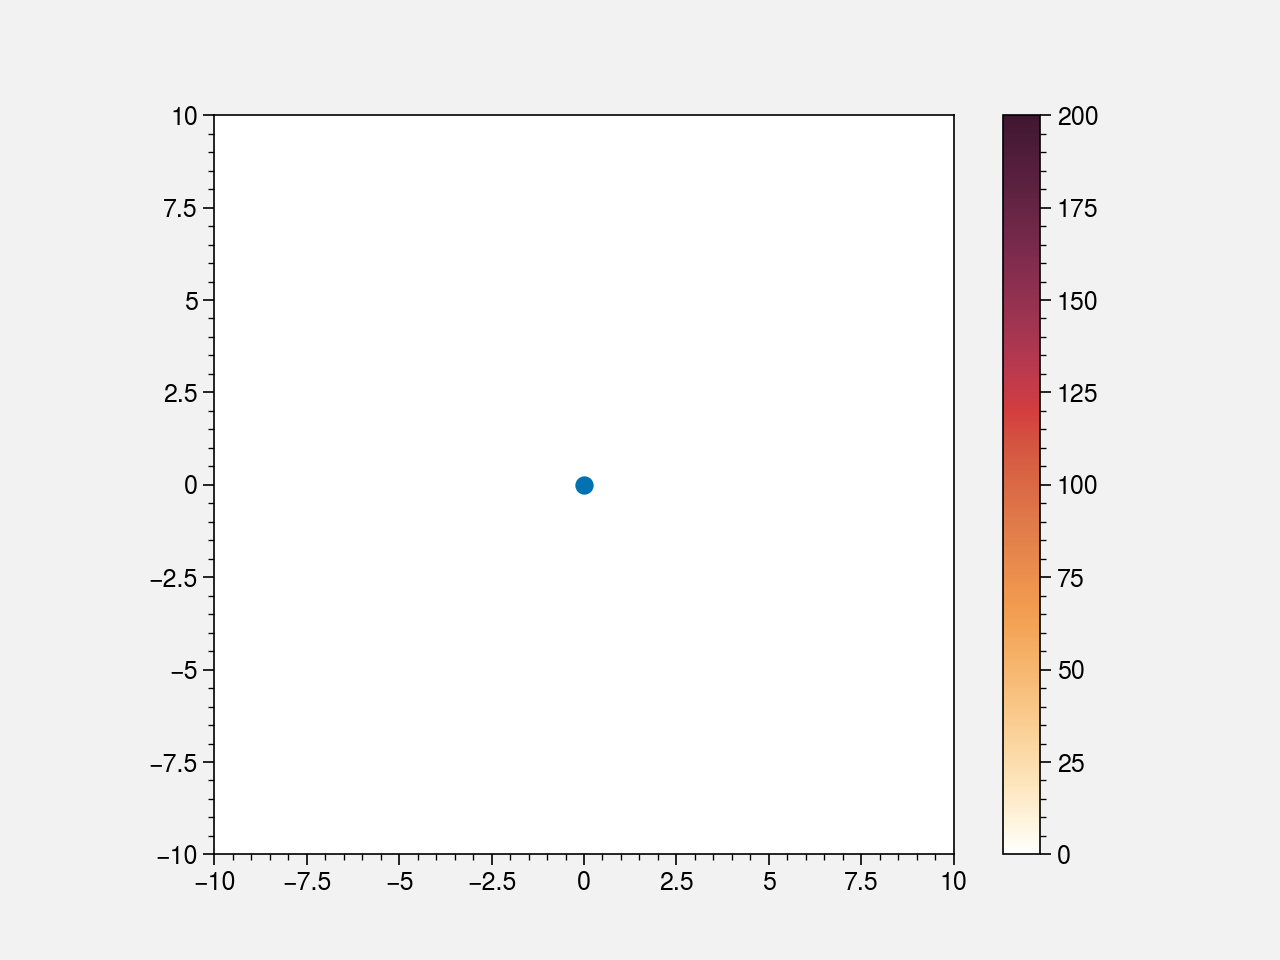

In [486]:
fig = plt.figure()
ax = plt.subplot()
c = ax.pcolormesh(x,y,topo,vmax=200)
ax.set_aspect(1)
ax.set_xlim([-10,10])#
ax.set_ylim([-10,10])
ax.scatter(0,0)
plt.colorbar(c)

In [487]:
y_

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

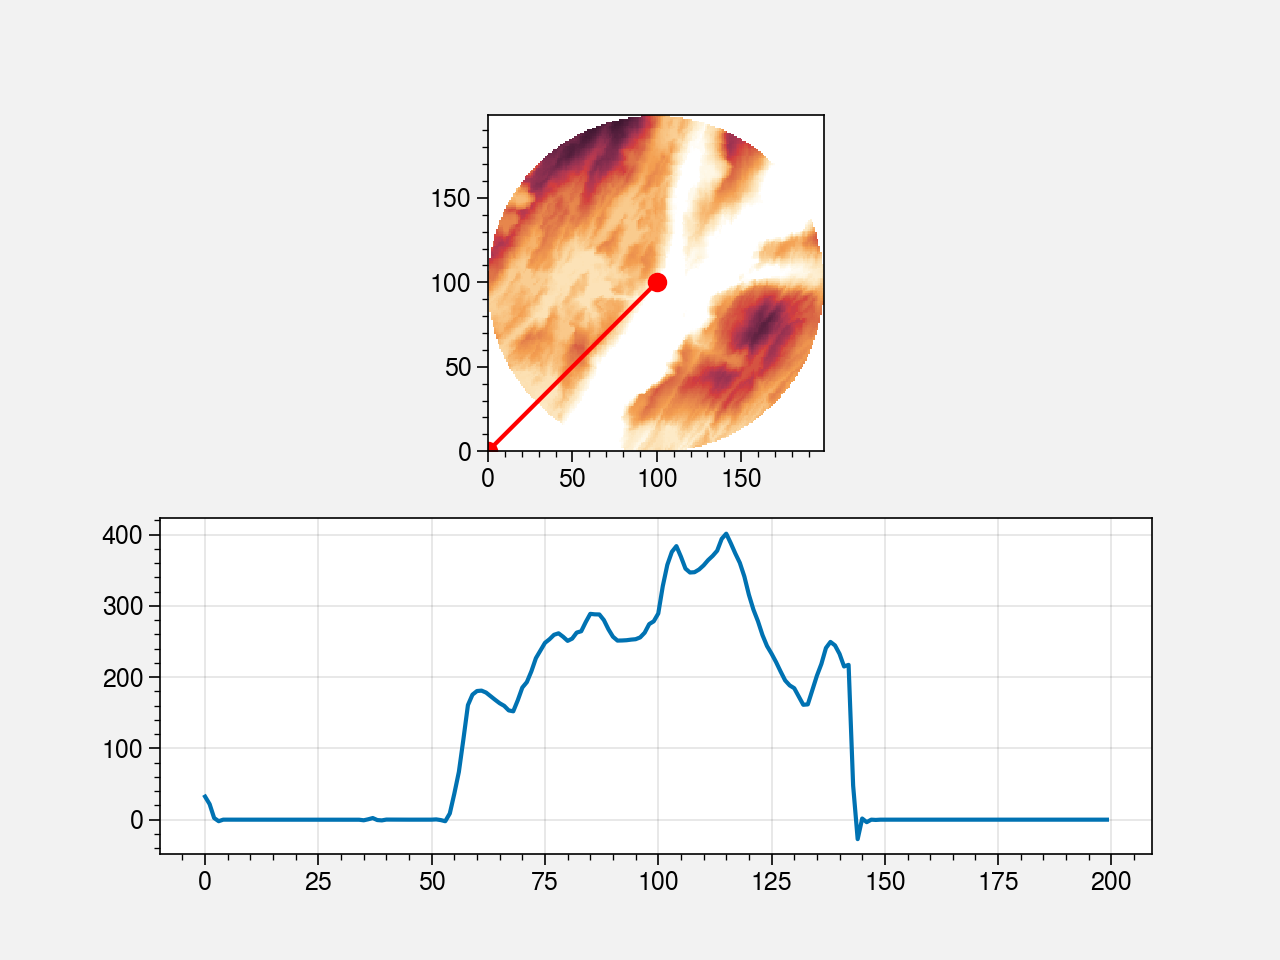

In [488]:
import scipy.ndimage as nd
#-- Generate some data...

#-- Extract the line...
# Make a line with "num" points...
x0, y0 = 100, 100 # These are in _pixel_ coordinates!!
x1, y1 = 0, 0
num = 200
x, y = np.linspace(x0, x1, num), np.linspace(y0, y1, num)

topo_ = np.fliplr(topo)


# Extract the values along the line, using cubic interpolation
zi = nd.map_coordinates(topo_, np.vstack((x,y)))

#-- Plot...
fig, axes = plt.subplots(nrows=2)
axes[0].pcolormesh(topo)
axes[0].plot([x0, x1], [y0, y1], 'ro-')
axes[0].axis('image')

axes[1].plot(zi)

plt.show()

Above is in the same coordinate system as the angles defined in the plot; so then I can find the angle of my line and look compare it to the azimuth angle

In [489]:
np.rad2deg(phi)

array([ 0., 45., 45., 45., 45., 45., 45., 45., 45., 45., 45., 45., 45.,
       45., 45., 45., 45., 45., 45., 45., 45., 45., 45., 45., 45., 45.,
       45., 45., 45., 45., 45., 45., 45., 45., 45., 45., 45., 45., 45.,
       45., 45., 45., 45., 45., 45., 45., 45., 45., 45., 45., 45., 45.,
       45., 45., 45., 45., 45., 45., 45., 45., 45., 45., 45., 45., 45.,
       45., 45., 45., 45., 45., 45., 45., 45., 45., 45., 45., 45., 45.,
       45., 45., 45., 45., 45., 45., 45., 45., 45., 45., 45., 45., 45.,
       45., 45., 45., 45., 45., 45., 45., 45., 45.])

Find nearest angle of the azimuth

In [490]:
sun_today.query('zenith>0')

azimuth     zenith
2021-04-15 05:00:00+00:00   76.870447   4.089276
2021-04-15 06:00:00+00:00   89.819134  11.323953
2021-04-15 07:00:00+00:00  103.103177  18.640590
2021-04-15 08:00:00+00:00  117.197940  25.570876
2021-04-15 09:00:00+00:00  132.563487  31.636256
2021-04-15 10:00:00+00:00  149.496607  36.295019
2021-04-15 11:00:00+00:00  167.873145  38.996894
2021-04-15 12:00:00+00:00  186.957692  39.345325
2021-04-15 13:00:00+00:00  205.634848  37.285163
2021-04-15 14:00:00+00:00  223.015216  33.133755
2021-04-15 15:00:00+00:00  238.810035  27.419664
2021-04-15 16:00:00+00:00  253.226528  20.698124
2021-04-15 17:00:00+00:00  266.698717  13.466029
2021-04-15 18:00:00+00:00  279.705455   6.178580

In [493]:
#-- Extract the line...
# Make a line with "num" points...
x0, y0 = 100, 100 # These are in _pixel_ coordinates!!
x1, y1 = 0, 0
num = 200
x, y = np.linspace(x0, x1, num), np.linspace(y0, y1, num)

topo = np.fliplr(topo)


# Extract the values along the line, using cubic interpolation
zi = nd.map_coordinates(topo, np.vstack((x,y)))

In [494]:
tan_ = np.tan(np.deg2rad(76))

In [495]:
mot = 100/tan_

In [505]:
def azimuth_topo(az,topo,do_plot=False): 
    hos = np.cos(np.deg2rad(az-180))*100
    mot = np.sin(np.deg2rad(az-180))*100

    #-- Extract the line...
    # Make a line with "num" points...
    x0, y0 = 100, 100 # These are in _pixel_ coordinates!!
    x1, y1 = mot+100,hos+100
    num = 200
    x, y = np.linspace(x0, x1, num), np.linspace(y0, y1, num)

    zi = nd.map_coordinates(topo, np.vstack((x,y)))
    if do_plot:
        fig, axes = plt.subplots(nrows=2)
        axes[0].pcolormesh(topo)
        axes[0].plot([x0, x1], [y0, y1], 'ro-')
        axes[0].axis('image')

        axes[1].plot(zi)
    
    
    return zi

In [519]:
z_.shape

(200,)

In [522]:
Z = np.ones((len(sun_today.azimuth),200))

for ii,az in enumerate(sun_today.azimuth): 

    z_ = azimuth_topo(az,topo)
    
    Z[ii] = z_
    

In [572]:
def pol2cart( phi):
    x = 1000 * np.cos(np.deg2rad(phi))
    y = 1000 * np.sin(np.deg2rad(phi))
    return(x, y)

xx,yy = pol2cart(sun_today.zenith)

25.570876161703836


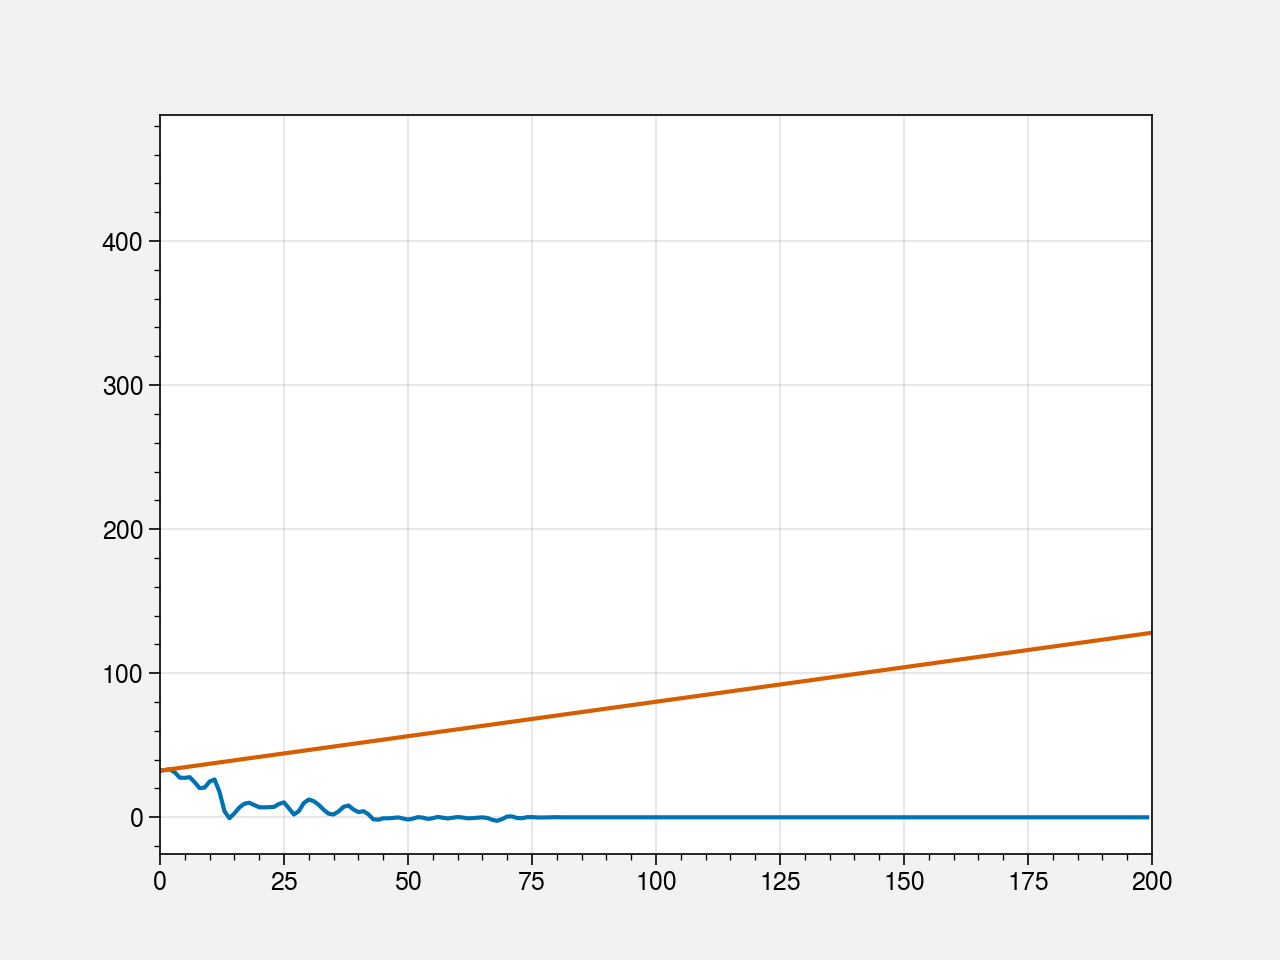

In [618]:
ii = 8
plt.plot(Z[ii])
plt.plot([0,xx[ii]],[z_[0],z_[0]+yy[ii]])
plt.xlim([0,200])
print(sun_today.iloc[ii].zenith)

Nå har jeg egentlig alt jeg trenger - sol vinkel som stemmer med azimuth vinkel som stemmer med topografidataen; 

- finn de lokale maskimumene i topografidataen



In [666]:
from scipy.signal import find_peaks

In [832]:
def find_angle(Z):
    x = np.arange(0,200)
    pks,_=find_peaks(Z_,height=Z_[0])
    angles = []
    for pk in pks:
        angle = np.rad2deg(np.arctan((Z[pk]-Z[0])/x[pk]))
        angles.append(angle)
    angle = np.max(angles)
    return angle

66.05443153639399


(0.0, 200.0)

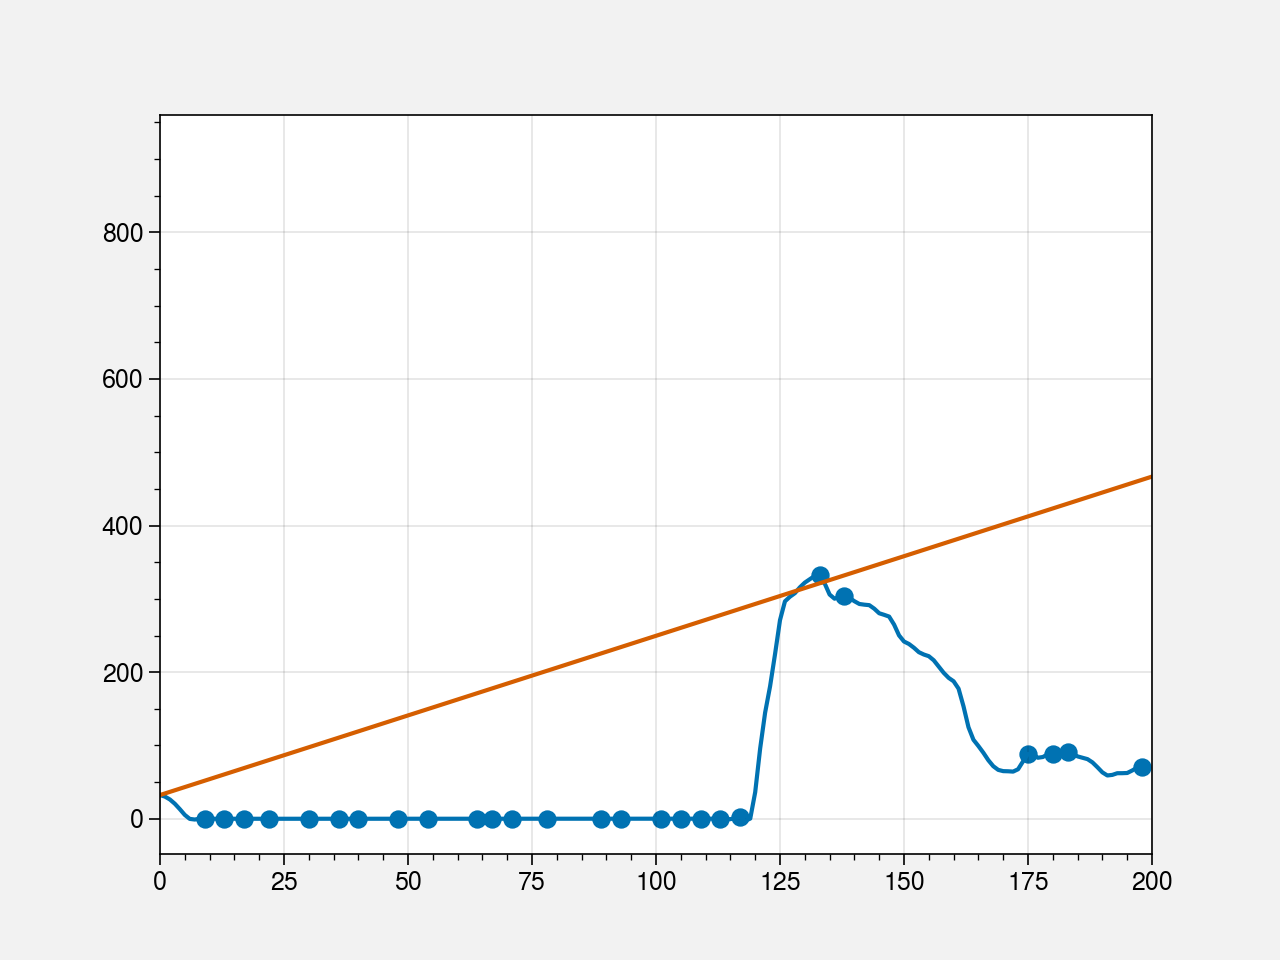

In [823]:
ii = 6
Z_ = Z[ii]
plt.plot(Z_)
x = np.arange(0,200)

pks,_=find_peaks(Z_)
plt.scatter(x[pks],Z_[pks])

angles = find_angle(Z[ii])
angle = np.max(angles)
print(angle)

xx,yy = pol2cart(angle)
plt.plot([0,xx],[Z_[0],yy])

plt.xlim([0,200])

Then, we can find the maximum angle corresponding to the topography angle the sun has to be above; so now; all we have to do is to make a matrix to see if the sun is higher than the required angle

* Let's start with the sun today

In [826]:
sun_df.head()

azimuth     zenith
2020-12-31 23:00:00+00:00  344.399202 -51.850322
2021-01-01 00:00:00+00:00    6.946902 -52.406193
2021-01-01 01:00:00+00:00   28.784728 -50.129956
2021-01-01 02:00:00+00:00   48.231270 -45.522252
2021-01-01 03:00:00+00:00   65.009736 -39.352765

In [846]:
Z = np.ones((len(sun_today.azimuth),200))
sunny_df = pd.DataFrame(index=sun_today.index,columns=['sun'])
for ii,time in enumerate(sun_today.index):
    az = sun_today.loc[time].azimuth
    ze = sun_today.loc[time].zenith
    z_ = azimuth_topo(az,topo)
    angle = find_angle(z_)

    if angle<ze:
        sunny_df.loc[time]['sun'] = True
    else: 
        sunny_df.loc[time]['sun'] = False
    
    

In [848]:
sunny_df

sun
2021-04-15 00:00:00+00:00  False
2021-04-15 01:00:00+00:00  False
2021-04-15 02:00:00+00:00  False
2021-04-15 03:00:00+00:00  False
2021-04-15 04:00:00+00:00  False
2021-04-15 05:00:00+00:00  False
2021-04-15 06:00:00+00:00  False
2021-04-15 07:00:00+00:00   True
2021-04-15 08:00:00+00:00   True
2021-04-15 09:00:00+00:00  False
2021-04-15 10:00:00+00:00  False
2021-04-15 11:00:00+00:00   True
2021-04-15 12:00:00+00:00  False
2021-04-15 13:00:00+00:00  False
2021-04-15 14:00:00+00:00  False
2021-04-15 15:00:00+00:00  False
2021-04-15 16:00:00+00:00  False
2021-04-15 17:00:00+00:00  False
2021-04-15 18:00:00+00:00  False
2021-04-15 19:00:00+00:00  False
2021-04-15 20:00:00+00:00  False
2021-04-15 21:00:00+00:00  False
2021-04-15 22:00:00+00:00  False
2021-04-15 23:00:00+00:00  False

---

So now, we just have to do that for every day of the year

In [ ]:
Z = np.ones((len(sun_df.azimuth),200))
sunny_df = pd.DataFrame(index=sun_df.index,columns=['sun'])
for ii,time in enumerate(sun_df.index):
    az = sun_df.loc[time].azimuth
    ze = sun_df.loc[time].zenith
    z_ = azimuth_topo(az,topo)
    angle = find_angle(z_)

    if angle<ze:
        sunny_df.loc[time]['sun'] = True
    else: 
        sunny_df.loc[time]['sun'] = False
    

In [659]:
sr = []
ss = []
for doy in np.arange(1,366): 
    idx_ = sun_df.query('index.dt.day_of_year==@doy and index.dt.hour < 14').zenith.sub(0).abs().idxmin()
    sr.append(idx_.hour)
    
    idx_ = sun_df.query('index.dt.day_of_year==@doy and index.dt.hour > 14').zenith.sub(0).abs().idxmin()
    ss.append(idx_.hour)

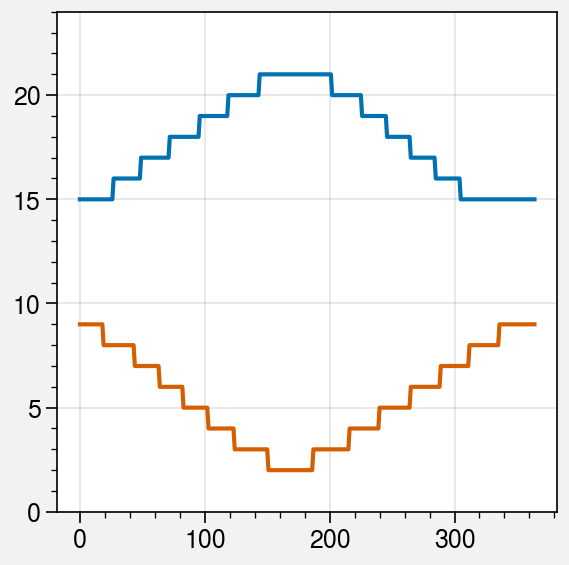

In [662]:
fix, ax = plot.subplots()
ax.plot(ss)
ax.plot(sr)
ax.format(ylim=[0,24])